In [56]:
library(sp)
library(rgdal)
library(tmap)
library(raster)
data(meuse)
coordinates(meuse) = ~x+y
data(meuse.grid)
gridded(meuse.grid) = ~x+y

Warning message in sp::proj4string(obj):
"CRS object has comment, which is lost in output"

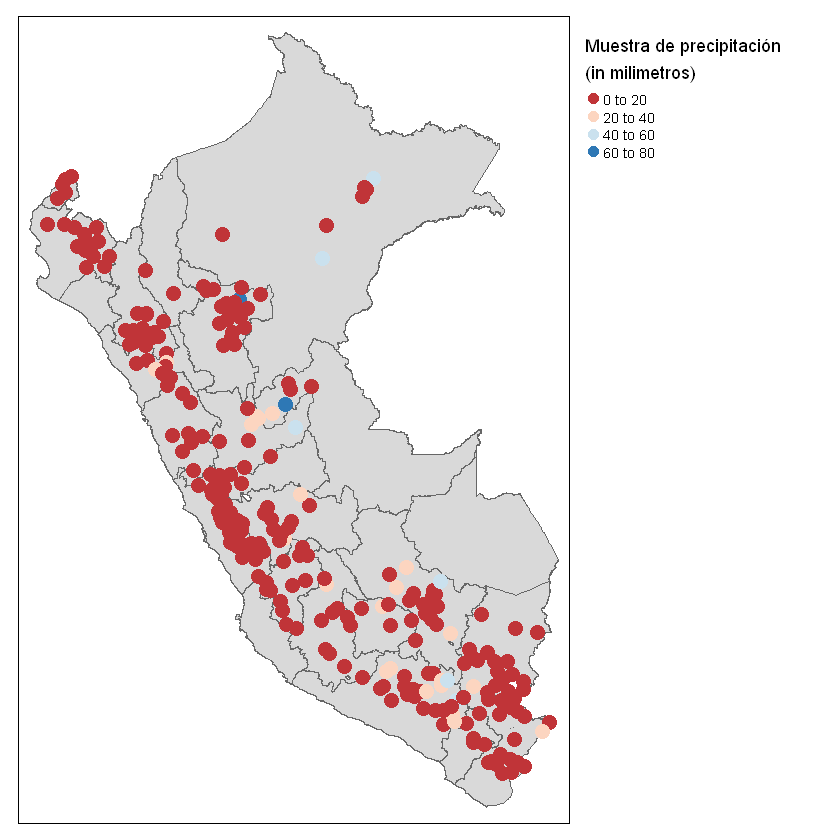

In [91]:
P <- read.csv('D:/Proyectos_GitHub/curso_hidrologia/data/Estaciones/estaciones_interpolacion.csv')
coordinates(P) = ~x+y
proj4string(P)='+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0'
W <- shapefile('D:/Proyectos_GitHub/curso_hidrologia/data/shp/departamentos/Departamento_gcs.shp')

# Replace point boundary extent with that of Texas
P@bbox <- W@bbox

tm_shape(W) + tm_polygons() +
  tm_shape(P) +
  tm_dots(col="pp", palette = "RdBu",
             title="Muestra de precipitación \n(in milimetros)", size=0.7) +
  tm_legend(legend.outside=TRUE)

# Poligonos de Thiesen

Es un método de interpolación simple basado en la distancia euclidiana y mediatrices. Estas formaciones geométricas también se les conoce como diagramas de Voronoi. Una vez particionado el área en base la información discreta de puntos de medición, se asigna valores a las ubicaciones que no cuenten con medición acorde a la estación más cercana a dicha ubicación.

In [96]:
#Pronto, falta implementar

# Ponderación de distancia Inversa (IDW)

$\Large u(x)=\begin{cases}
            \frac{\sum_{i=1}^{N} w_i(x)u_i}{\sum_{i=1}^{N} w_i(x)}, &         \text{if } d(x,x_i)\neq 0,\\
            u_i, &         \text{if } d(x,x_i) = 0.
    \end{cases}$

Para IDW los pesos $w_i$ son una función arbitraria de la siguiente forma

$\Large  w_i(x)  =\frac{1}{d(x,x_i)^p} $

Warning message in proj4string(P):
"CRS object has comment, which is lost in output"Warning message in proj4string(obj):
"CRS object has comment, which is lost in output"Warning message in proj4string(P):
"CRS object has comment, which is lost in output"Warning message in proj4string(d$data):
"CRS object has comment, which is lost in output"Warning message in proj4string(newdata):
"CRS object has comment, which is lost in output"

[inverse distance weighted interpolation]


Warning message in proj4string(newdata):
"CRS object has comment, which is lost in output"Warning message:
"The argument auto.palette.mapping is deprecated. Please use midpoint for numeric data and stretch.palette for categorical data to control the palette mapping."

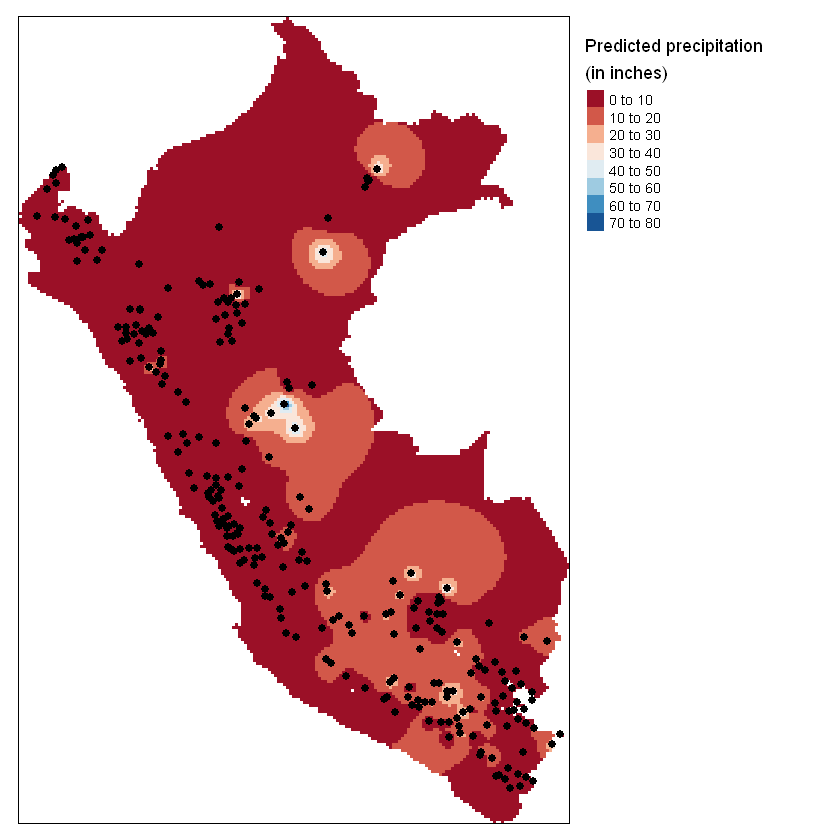

In [95]:
library(gstat) # Use gstat's idw routine
library(sp)    # Used for the spsample function

# Create an empty grid where n is the total number of cells
grd              <- as.data.frame(spsample(P, "regular", n=50000))
names(grd)       <- c("X", "Y")
coordinates(grd) <- c("X", "Y")
gridded(grd)     <- TRUE  # Create SpatialPixel object
fullgrid(grd)    <- TRUE  # Create SpatialGrid object

# Add P's projection information to the empty grid
proj4string(P) <- proj4string(P) # Temp fix until new proj env is adopted
proj4string(grd) <- proj4string(P)

# Interpolate the grid cells using a power value of 2 (idp=2.0)
P.idw <- gstat::idw(pp ~ 1, P, newdata=grd, idp=2.0)

# Convert to raster object then clip to Texas
r       <- raster(P.idw)
r.m     <- mask(r, W)

# Plot
tm_shape(r.m) + 
  tm_raster(n=10,palette = "RdBu", auto.palette.mapping = FALSE,
            title="Predicted precipitation \n(in inches)") + 
  tm_shape(P) + tm_dots(size=0.2) +
  tm_legend(legend.outside=TRUE)

# Aproximaciones Kriging

Las diferentes variaciones de Kriging se basan en una regresion lineal $Z^*(u)$ definido como:

$$\Large
Z^*(u)-m(u)= \sum_{i=a}^{n(u)} \lambda_i(u)[Z(u_a)-m(u_a)]
$$

$donde:$

$u,u_a$ : son los vectores posicion hacia el punto de estimacion y los vecinos de esa estacion indexados con a



Como los métodos de interpolación anterior, se requiere estimar los valores de $\lambda_a$, que minimice la varianza del estimador

$$\Large \sigma_E^2(u)=Var[Z^*(u)-Z(u)]$$

Como deseamos que el valor estimado este cercano al valor real, se requiere que la diferencia entre ambos idealmente sea cero. Es por ello que la varianza del estimador tiene que ser minimizado con esa restricción.

Esto se puede expresar como:

$$\Large E[Z^*(u)-Z(u)]=0 $$

La variable aleatoria Z(u) es descompuesto como la suma de un valor residual y un valor promedio de los vecinos. Es decir $Z(u)= R(u)+m(u)$. El residual debe tender a cero y tener una covarianza estacionaria.

$$\large E[R(u)]=0 $$

$$\large Cov[R(u),R(u+h)] = E[R(u)R(u+h)] =C_R(h) $$

### Kriging simple

Para Kriging simple se asumen que el valor de tendencia es una media constante y conocida $m(u)=m$. Esto simplifica la expresion de estimación:

$$\Large
Z^*(u)= m+ \sum_{i=a}^{n(u)} \lambda_i(u)[Z(u_a)-m]
$$

Esta asunción ya nos da el insesgamiento de manera gratuita ya que $E[Z(u_a)-m]=0$ causando que $E[Z^*(u)]=m=E[Z(u)]$

Propiedades a considerar para los siguientes cálculos:

Sean las variables aleatorios X y Y

$\Large Var(aX-bY) = a^2Var(X)+b^2Var(Y)-abCov(X,Y)$

$\Large Cov(X_i,X_i)=Var(X_i) $

El error del estimador $ Z^*(u)-Z(u)$ puede ser expresado como una combinacion linear de los residuales vecinos,$u_a$, y el punto a estimar:

$$\Large
Z^*(u)-Z(u) = [Z^*(u)-m]-[Z(u)-m]=\sum_{i=a}^{n(u)} \lambda_i(u)R(u_a)-R(u)=R^*(u)-R(u)
$$



Podemos calcular la varianza de esta diferencia como:

$$\Large
\sigma^2_E(u)=Var[Z*(u)-Z(u)]=Var[R^*(u)-R(u)]
$$

dado que $R^*(u)$ y $R(u)$ son variables aleatorias, podemos relacionar las varianzas de la siguiente manera:

$$\Large
\sigma^2_E(u)=Var[R^*(u)]+Var[R(u)]-2Cov[R^*(u)R(u)]
$$

Expresado en componentes se tiene :

$$\Large
\sigma^2_E(u)= \sum_{i=a}^{n(u)} \sum_{i=b}^{n(u)} \lambda_a(u) \lambda_b(u)C_R(u_a-u_b)+C_R(0)-2\sum_{i=a}^{n(u)} \lambda_a(u)C_R(u_a-u)
$$

Para minimizar la varianza se tiene que derivar la expresión anterior con respecto a cada uno de los pesos de kriging

$$\Large
 \frac{\delta }{\delta\lambda_k}\Bigg[\sigma^2_E(u)= \sum_{i=a}^{n(u)} \sum_{i=b}^{n(u)} \lambda_a(u) \lambda_b(u)C_R(u_a-u_b)+C_R(0)-2\sum_{i=a}^{n(u)} \lambda_a(u)C_R(u_a-u)\Bigg]
$$

Tener en cuenta que:

$\Large \frac{\delta \lambda_i}{\delta\lambda_j}=\delta_{ij}=\begin{cases}
            1, &         \text{if } i=j,\\
            0, &         \text{if } i\neq j.
    \end{cases}$


Se obtiene las siguientes ecuaciones

$$\Large
\sum_{i=b}^{n(u)} \lambda_b(u)C_R(u_a-u_b)=C_R(u_a-u) $$ $$ para$$ $$ a=1,...n(u)
$$

### Kriging Ordinario

In [ ]:
# falta implementar